In [21]:
import pandas as pd

In [22]:
# get search queries
df_query = pd.read_csv("../data/WANDS/dataset/query.csv", sep='\t')
df_query.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [23]:
# get products
df_product = pd.read_csv("../data/WANDS/dataset/product.csv", sep='\t')
df_product.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [24]:
# get manually labeled groundtruth lables
df_label = pd.read_csv("../data/WANDS/dataset/label.csv", sep='\t')
df_label.head()

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,5,0,41156,Exact


<Axes: >

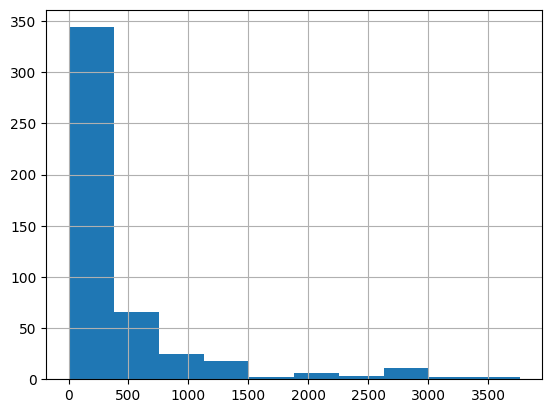

In [25]:
df_label['query_id'].value_counts().hist()

In [26]:
df_label[df_label.duplicated(subset=['query_id', 'product_id'])]

,id,query_id,product_id,label
9763,11242,87,41180,Partial
18662,21650,0,31306,Partial
18722,21714,6,31306,Partial
18723,21715,6,22389,Partial
18759,21761,12,34349,Partial
...,...,...,...,...
95073,109655,221,34678,Partial
95075,109657,221,42991,Partial
95077,109659,221,39006,Partial
95079,109661,221,14598,Partial


<Axes: >

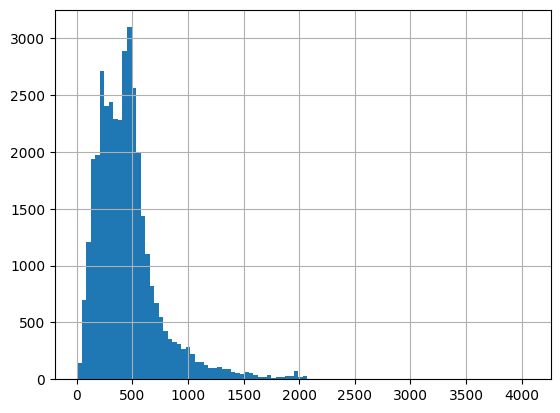

In [27]:
df_product = df_product.dropna(subset=['product_description'])
df_product['product_description'].map(len).hist(bins=100)

In [28]:
df_product = pd.read_csv("../data/WANDS/dataset/product.csv", sep='\t')
nan_list = df_product[df_product['product_description'].isna()].product_id.to_list()
print(nan_list)

[]


In [31]:
# 欠損値を削除

df_query = pd.read_csv("../data/WANDS/raw_data/query.csv", sep='\t')
df_product = pd.read_csv("../data/WANDS/raw_data/product.csv", sep='\t')
df_label = pd.read_csv("../data/WANDS/raw_data/label.csv", sep='\t')

df_product = df_product[~df_product['product_id'].isin(nan_list)]
df_label = df_label[~df_label['product_id'].isin(nan_list)]

print(df_product.shape, df_product.shape)
print(df_label.shape, df_label.shape)

# 重複を削除
df_label = df_label.drop_duplicates(subset=['query_id', 'product_id'])

df_product.to_csv("../data/WANDS/dataset/product.csv", sep='\t', index=False)
df_label.to_csv("../data/WANDS/dataset/label.csv", sep='\t', index=False)

(42994, 9) (42994, 9)
(233448, 4) (233448, 4)


### 評価のためにデータセットを整理する

In [8]:
# idが得られたとして、gainとrankを算出する
import numpy as np

query = 0
id = [25434, 12088]
id_score = [
    {'id': 25434, 'score': 1.0},
    {'id': 12088, 'score': 0.5}
]

df = pd.DataFrame(id_score)
df['label'] = df_label[(df_label['query_id'] == query) & df_label['product_id'].isin(id)]['label']
df['gain'] = df['label'].replace({'Exact': 1, 'Partial': 0.5, 'Irrelevant': 0})

df

,id,score,label,gain
0,25434,1.0,Exact,1
1,12088,0.5,Irrelevant,0


In [9]:
# NDCGスコア
from sklearn.metrics import ndcg_score

y_true = np.array([[1,1,0.5,0]]) # 正解値
y_score = np.array([[3,2,1,0]]) # 予測値

ndcg_score(y_true, y_score)

1.0

In [10]:
# MRR
from sklearn.metrics import label_ranking_average_precision_score

y_true = np.array([[0,1,1,0], [0,0,0,1]]) # 正解値
y_score = np.array([[3,4,1,0], [1,1,2,1]]) # 予測値

label_ranking_average_precision_score(y_true, y_score)

0.5416666666666666

In [11]:
# precision
from sklearn.metrics import precision_score

y_true = np.array([0,1,1,0]) # 正解値
y_score = np.array([3,4,1,0]) # 予測値

precision_score(y_true, y_score, average='micro')

0.5